In [8]:
import matplotlib
#matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

from collections import namedtuple

%load_ext autoreload
%autoreload 2

from bsee_data_processing import bsee_plots
from bsee_data_processing.bsee_load import load_bsee


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
logdir = Path("/home/bsee/bsee_data/CRREL_2024-02-05/240205_201616_2024-02-05-pool-test/extracted")
mission = "240205_201616_2024-02-05-pool-test"

data = load_bsee(logdir, mission, relative_time = True)

print(data.imaging_metadata)


power
Index(['ros_time', 'voltage', 'current', 'power'], dtype='object')
       ros_time   voltage  current  power                            datetime
0  1.707164e+09  23.62000  0.34750   8.20 2024-02-05 20:16:20.119867086+00:00
1  1.707164e+09  23.61875  0.34625   8.18 2024-02-05 20:16:20.219960928+00:00
2  1.707164e+09  23.62250  0.34500   8.15 2024-02-05 20:16:20.319916487+00:00
3  1.707164e+09  23.62125  0.35500   8.12 2024-02-05 20:16:20.419820309+00:00
par
Index(['ros_time', 'irradiance', 'temperature'], dtype='object')
       ros_time  irradiance  temperature                            datetime
0  1.707164e+09      -0.004        11.91 2024-02-05 20:17:30.352310419+00:00
1  1.707164e+09      -0.013        11.91 2024-02-05 20:17:30.466537714+00:00
2  1.707164e+09      -0.008        11.91 2024-02-05 20:17:30.581176996+00:00
3  1.707164e+09      -0.016        11.91 2024-02-05 20:17:30.695146322+00:00
htp
Index(['ros_time', 'percent_humidity', 'temperature_C', 'pressure_Pa'], dtype='

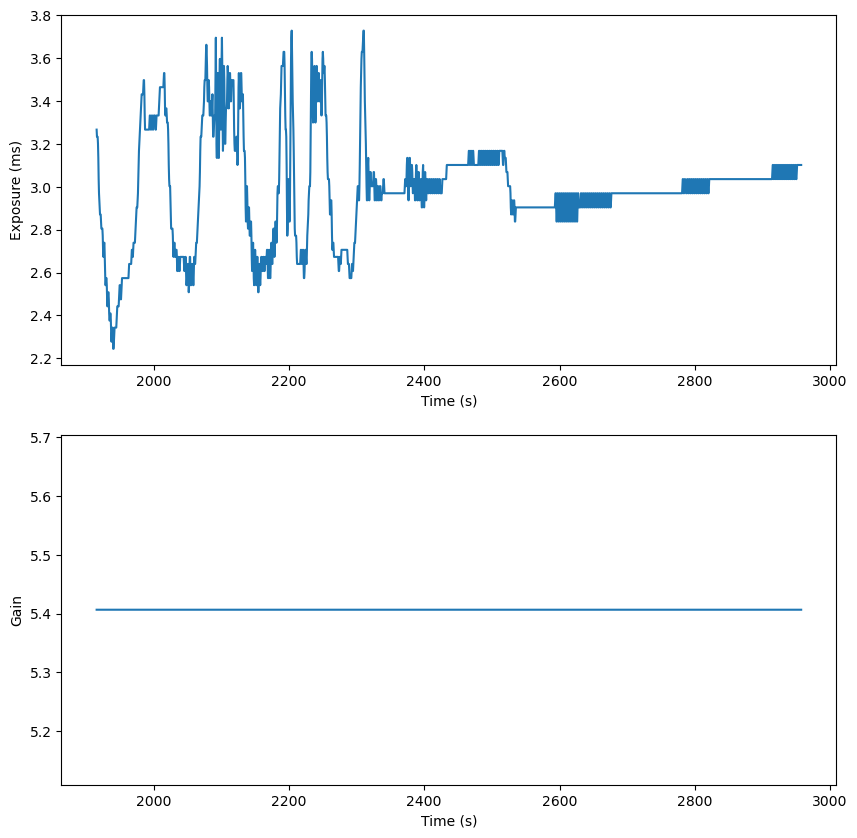

In [11]:
fig, ax = plt.subplots(2, figsize=(10,10))

bsee_plots.imaging_exposure_plot(data, ax[0])
bsee_plots.imaging_gain_plot(data, ax[1])

         
#plt.savefig("lights.png")

----
# Old code below here
----

In [ ]:
def load_bme280(logdir, mission):
    datafile = os.path.join(logdir, "extracted", f"{mission}_bme280_htp.txt")
    data = []
    for line in open(datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(' ')
        values = list(map(float, tokens))
        data.append(values)
    return pd.DataFrame(data, columns=['seconds', 'humidity','temperature','pressure'])

bme = load_bme280(logdir,mission)
print(bme)


In [ ]:
def load_uvilux(logdir, mission):
    datafile = os.path.join(logdir, "extracted", f"{mission}_uvilux.txt")
    data = []
    for line in open(datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(' ')
        values = list(map(float, tokens))
        data.append(values)
    return pd.DataFrame(data, columns=['seconds', 'fluoresence','eht_voltage', 'quality_flags'])

uvilux = load_uvilux(logdir, mission)
print(uvilux)

In [ ]:
plt.plot(power['seconds'], power['power'])
plt.plot(par['seconds'], par['irradiance'])

In [ ]:
def interpolate_depth(posix_times, remus_data):
    remus_depth_idx = 3
    dd = np.interp(posix_times, remus_data[:,0], remus_data[:,remus_depth_idx])
    return dd

In [ ]:
# plot science values as a function of depth
def plot_data_depth(logdir, mission):
    #gtd_data = load_gtd(logdir, mission)
    #oxygen_data = load_sbe43(logdir, mission)
    #htp_data = load_bme280(logdir, mission)
    #ctd_data = load_ctd(logdir, mission)
    #remus_data = load_recon(logdir, mission)
    
    fig = plt.figure(figsize=(15, 10))
    gtd_ax, ctd_ax, oxy_ax = fig.subplots(1,3)

    gtd_depth = interpolate_depth(gtd_data[:,0], remus_data) 
    gtd1_idx = gtd_field_idxs["mems1_pressure"]
    gtd2_idx = gtd_field_idxs["mems2_pressure"]

    gtd_ax.plot(gtd_data[:,gtd1_idx], gtd_depth, 'k.', label='mems1')
    gtd_ax.plot(gtd_data[:,gtd2_idx], gtd_depth, 'r.', label='mems2')
    gtd_ax.set_xlabel("GTD MEMS pressure (mbar)")
    gtd_ax.set_ylabel("Depth from Recon (m)")
    gtd_ax.legend()

    oxy_depth = interpolate_depth(oxygen_data[:,0], remus_data)
    oxy_im = oxy_ax.scatter(oxygen_data[:,1], oxy_depth, c=oxygen_data[:,0], s=10, ec="none")
    oxy_ax.set_xlabel('Oxygen Concentration (mL/L)')
    oxy_ax.set_ylabel('Depth from Recon (m)')
    oxy_cbar = fig.colorbar(oxy_im, ax=oxy_ax, label="time (s)")

    ctd_depth = interpolate_depth(ctd_data[:,0], remus_data) 
    cond_idx = 1
    temp_idx = 2
    pressure_idx = 3
    ctd_ax.plot(ctd_data[:,temp_idx], ctd_depth, 'k.', markersize=2, label="Temperature")
    set_ax_color(ctd_ax, 'black', 'x')
    ctd_ax2 = ctd_ax.twiny()
    ctd_ax2.plot(ctd_data[:,cond_idx], ctd_depth, 'r.', markersize=2, label="Conductivity")
    set_ax_color(ctd_ax2, 'red', 'x')
    #ctd_ax3 = ctd_ax.twiny()
    #ctd_ax3.plot(ctd_data[:,pressure_idx], ctd_depth, 'g.', label="Pressure")
    ctd_ax.set_xlabel("Temperature (C) from Recon")
    ctd_ax2.set_xlabel("Conductivity from Recon")
    #ctd_ax3.set_xlabel("Pressure from Recon")

    ctd_ax.set_ylabel("Depth from Recon (m)")

    fig.suptitle(mission)

    for ax in [gtd_ax, oxy_ax, ctd_ax]:
        ylim = ax.get_ylim()
        ax.set_ylim((ylim[1], ylim[0]))

    fig.savefig(f"{mission}_depth_plots.png", dpi=300)



In [ ]:
plot_data_depth(logdir, mission)

In [ ]:
import datetime
import matplotlib.ticker
from matplotlib.ticker import FuncFormatter
class TimeFormatter(matplotlib.ticker.Formatter):
    def __call__(val, pos=None):
        dt = datetime.datetime.fromtimestamp(val)
        ss = dt.strftime("%Y-%m-%d %H:%M:%S")
        return ss

In [ ]:
def set_ax_color(ax, color, which):
    """Set axis label / ticks / legend to given color"""
    # TODO: I can't figure out how to get the tick labels to be colored.
    ax.tick_params(which='both', color=color, labelcolor=color)
    if which == 'x':
        ax.xaxis.label.set_color(color)
    else:
        ax.yaxis.label.set_color(color)

In [ ]:
# plot science values as a function of depth
def plot_data_time(logdir, mission):
    #gtd_data = load_gtd(logdir, mission)
    #oxygen_data = load_sbe43(logdir, mission)
    #htp_data = load_bme280(logdir, mission)
    #ctd_data = load_ctd(logdir, mission)
    #remus_data = load_recon(logdir, mission)
    
    fig = plt.figure(figsize=(15, 10))
    state_ax, gtd_ax, ctd_ax, oxy_ax = fig.subplots(4, 1)

    state_ax.plot(remus_data[:,0], remus_data[:,3], 'k.', markersize=2)
    set_ax_color(state_ax, 'black', 'y')
    state_ax.set_ylabel("Vehicle Depth (m)")
    ylim = state_ax.get_ylim()
    state_ax.set_ylim([ylim[1], ylim[0]])
    state_ax2 = state_ax.twinx()
    state_ax2.plot(remus_data[:,0], remus_data[:, 6], 'r.', markersize=2)
    set_ax_color(state_ax2, 'red', 'y')
    state_ax2.set_ylabel("Vehicle Heading (deg)")
    state_ax.set_xlabel("Time")
    
    gtd1_idx = gtd_field_idxs["mems1_pressure"]
    gtd2_idx = gtd_field_idxs["mems2_pressure"]

    gtd_ax.plot(gtd_data[:,0], gtd_data[:,gtd1_idx], 'k.', markersize=2, label='mems1')
    gtd_ax.plot(gtd_data[:,0], gtd_data[:,gtd2_idx], 'r.', markersize=2, label='mems2')
    gtd_ax.set_ylabel("GTD pressure (mbar)")
    gtd_ax.set_xlabel("Time")
    gtd_ax.legend()

    oxy_ax.plot(oxygen_data[:,0], oxygen_data[:,1], 'k.', markersize=2)
    oxy_ax.set_ylabel('Oxygen Concentration (mL/L)')
    oxy_ax.set_xlabel('Time')

    cond_idx = 1
    temp_idx = 2
    pressure_idx = 3
    ctd_ax.plot(ctd_data[:,0], ctd_data[:,temp_idx], 'k.', markersize=2, label="Temperature")
    set_ax_color(ctd_ax, 'black', 'y')
    ctd_ax2 = ctd_ax.twinx()
    ctd_ax2.plot(ctd_data[:,0], ctd_data[:,cond_idx], 'r.', markersize=2, label="Conductivity")
    set_ax_color(ctd_ax2, 'red', 'y')
    # Seems that the Remus doesn't provide pressure
    #ctd_ax3 = ctd_ax.twinx()
    #ctd_ax3.plot(ctd_data[:,0], ctd_data[:,pressure_idx], 'g.', markersize=2, label="Pressure")
    ctd_ax.set_ylabel("Temperature (C) from Recon")
    ctd_ax2.set_ylabel("Conductivity from Recon")
    #ctd_ax3.set_ylabel("Pressure from Recon")

    ctd_ax.set_xlabel("Time")
    # ctd_ax.legend()

    fig.suptitle(mission)

    fig.savefig(f"{mission}_time_plots.png", dpi=300)

    for ax in [state_ax, gtd_ax, oxy_ax, ctd_ax]:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S")))



In [ ]:
from matplotlib.ticker import FuncFormatter
plot_data_time(logdir, mission)

In [ ]:
# Mission 255 had wonky data; look at that more closely
fig = plt.figure(figsize=(15,10))
ax1, ax2 = fig.subplots(2,1)
t0 = gtd_data[0,0]

ax1.plot(gtd_data[:,0]-t0, 'k.')
ax1.set_title(f"GTD Timestamps for {mission}")

ax2.plot(gtd_data[:,0]-t0, gtd_data[:,11], 'k.')
ax2b = ax2.twinx()
ax2b.plot(gtd_data[:,0]-t0, gtd_data[:,gtd_field_idxs["mems1_pressure"]], 'r.', label='mems1 pressure')
ax2b.plot(gtd_data[:,0]-t0, gtd_data[:,gtd_field_idxs["mems2_pressure"]], 'b.', label='mems2 pressure')
ax2b.legend()
ax2c = ax2.twinx()
ax2c.plot(remus_data[:,0] - t0, remus_data[:,3], 'c.')
ax2.set_xlabel('Time since start of mission (sec)')


In [ ]:
gtd_data[1,:]

In [ ]:
len(fields)

In [ ]:
len(data[1])